In [47]:
# pip install opencv-python
import cv2 as cv

import matplotlib.pyplot as plt

In [48]:
# Load a neural network model from a TensorFlow-based model file. 
net = cv.dnn.readNetFromTensorflow('data/graph_opt.pb') ## weights

# Define input dimensions for the neural network.
inWidth = 368
inHeight = 368
# Set a threshold for body part detection confidence.
thr = 0.2

# Define a mapping of body part names to their corresponding indices.
BODY_PARTS = {
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3,
    "RWrist": 4, "LShoulder": 5, "LElbow": 6,
    "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12,
    "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17,
    "Background": 18
}

# Define pairs of body parts that represent connections for visualization.
POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
    ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
    ["Neck", "Nose"], ["Nose", "REye"],
    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]
]


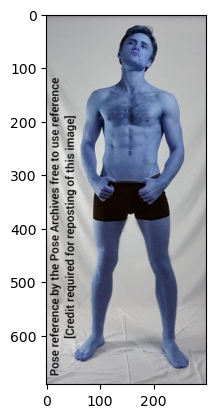

In [49]:
# Read an image from a file named "pose_3.jpg" located in the "assets" directory.
img = cv.imread("assets/pose_3.jpg")

# Display the loaded image using Matplotlib's imshow function.
# BGR (Blue-Green-Red) color format by default.
plt.imshow(img)

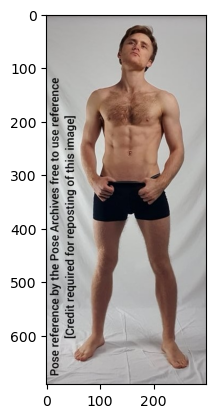

In [50]:
# Convert the BGR (Blue-Green-Red) image to RGB (Red-Green-Blue) color format.
# The 'img' variable contains the loaded BGR image.
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [51]:
def post_estimation(frame):
    # Get the width and height of the input frame.
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Prepare the frame for neural network input and pass it through the network.
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=False, crop=False))
    out = net.forward()

    # Extract the relevant part of the network output (only 19 elements are needed).
    out = out[:, :19, :, :]

    # Ensure the number of body parts defined is less than or equal to the number of output elements.
    assert(len(BODY_PARTS) <= out.shape[1])

    # Create an empty list to store points (coordinates of detected body parts).
    points = []

    for i in range(len(BODY_PARTS)):
        # Slice the heatmap corresponding to the body part.
        heatMap = out[0, i, :, :]

        # Find the maximum confidence point in the heatmap.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add the point to the list if its confidence is higher than the threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    # Visualize connections between body parts and draw keypoints.
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Measure and display the inference time on the frame.
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Return the frame with estimated and visualized body pose.
    return frame


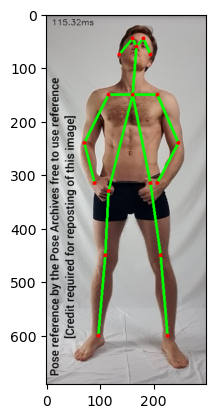

In [52]:
estimated_image = post_estimation(img)

plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
